# Yes, Transformers are Effective for Time Series Forecasting

## Introduction

A few months ago, we introduced the [Informer](https://huggingface.co/blog/informer) model ([Zhou, Haoyi, et al., 2021](https://arxiv.org/abs/2012.07436)), which is a Time Series Transformer that won the AAAI 2021 best paper award. We also provided an example for multivariate probabilistic forecasting with Informer. In this post, we introduce the _Autoformer_ model ([Wu, Haixu, et al., 2021](https://arxiv.org/abs/2106.13008)), which was published in NeurIPS 2021 after the Informer model. The Autoformer model is [now available](https://huggingface.co/docs/transformers/main/en/model_doc/autoformer) in 🤗 Transformers.

We will begin by explaining the Autoformer model, including its novel _Decomposition Layer_ and _Attention (Autocorrelation) Mechanism_. Next, we will present the _DLinear_ model, which is a simple feedforward network that uses the decomposition layer from Autoformer. The DLinear model was first introduced in [Are Transformers Effective for Time Series Forecasting?](https://arxiv.org/abs/2205.13504) which published recently in AAAI 2023. Finally, we will provide empirical evidence that **Transformers are indeed Effective for Time Series Forecasting**. Our comparison shows that a simple linear model is not better than Transformers, as claimed. When compared against equivalent sized models in the same setting as the the linear models, the Transformer based models perform better on the test set metrics we consider.

## Autoformer - Under The Hood

The Autoformer builds upon the traditional method of decomposing time series into seasonality and trend-cycle components. This is achieved through the incorporation of a _Decomposition Layer_, which enhances the model's ability to capture these components accurately. Moreover, the Autoformer introduces an innovative auto-correlation mechanism that replaces the standard self-attention used in the vanilla transformer. This mechanism enables the model to utilize period-based dependencies in the attention, thus improving the overall performence. 

In the upcoming sections, we will delve into the two key contributions of the Autoformer: the _Decomposition Layer_ and the _Attention (Autocorrelation) Mechanism_. We will also provide code examples to illustrate how these components function within the Autoformer architecture.

### Decomposition Layer
Decomposition has long been a popular method in time series analysis, but it had not been extensively incorporated into deep learning models until the introduction of the Autoformer paper. In the upcoming sections, we will introduce the general decomposition concept in time series analysis. Following that, we will demonstrate how this idea is applied in Autoformer using PyTorch code.

####  Decomposition of Time Series
In time series analysis, [decomposition](https://en.wikipedia.org/wiki/Decomposition_of_time_series) is a method of breaking down a time series into three systematic components, including trend-cycle, seasonal variation, and random fluctuations.
The trend component represents the long-term direction of the time series, which can be increasing, decreasing, or stable over time. The seasonal component represents the recurring patterns that occur within the time series, such as yearly or quarterly cycles. Finally, the random (sometimes called "irregular") component represents the random noise in the data that cannot be explained by the trend or seasonal components. 

Two main types of decomposition are additive and multiplicative decomposition, which implemented in the [great statsmodels library](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). By decomposing a time series into these components, we can better understand and model the underlying patterns in the data. 

But how can we incorporate decomposition into the transformer architecture? Let's see how Autoformer do it.

#### Decomposition in Autoformer

| ![autoformer_architecture](images/autoformer_architecture.png) |
|:--:|
| Autoformer architecture from [the paper](https://arxiv.org/abs/2106.13008) |

Autoformer incorporates a decomposition block as an inner operation of the model, as presented in the Autoformer's architecture above. As can be seen, the encoder and decoder use a decomposition block to aggregate the trend-cyclical part and extract the seasonal part from series progressively. The concept of inner decomposition has demonstrated its usefulness since the publication of Autoformer. Subsequently, it has been adopted in several other time series papers, such as FEDformer ([Zhou, Tian, et al., ICML 2022](https://arxiv.org/abs/2201.12740)) and DLinear [(Zeng, Ailing, et al., AAAI 2023)](https://arxiv.org/abs/2205.13504), highlighting its significance in time series modeling.

Now, let's define the decomposition layer formally:

For an input series $\mathcal{X} \in \mathbb{R}^{L \times d}$ with length $L$, the decomposition layer returns $\mathcal{X}_\textrm{trend}, \mathcal{X}_\textrm{seasonal}$ defined as:

$$
\mathcal{X}_\textrm{trend} = \textrm{AvgPool(Padding(} \mathcal{X} \textrm{))} \\
\mathcal{X}_\textrm{seasonal} = \mathcal{X} - \mathcal{X}_\textrm{trend}
$$

And the implementation in PyTorch:
```python
import torch
from torch import nn

class DecompositionLayer(nn.Module):
    """
    Returns the trend and the seasonal parts of the time series.
    """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) # moving average 

    def forward(self, x):
        """Input shape: Batch x Time x EMBED_DIM"""
        # padding on the both ends of time series
        num_of_pads = (self.kernel_size - 1) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        # calculate the trend and seasonal part of the series
        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend
```

As you can see, the implementation is quite simple and can be used in other models, as we will see with DLinear. Now, let's explain the second contribution - _Attention (Autocorrelation) Mechanism_.

### Attention (Autocorrelation) Mechanism

| ![autoformer_autocorrelation_vs_full_attention](images/autoformer_autocorrelation_vs_full_attention.png) |
|:--:|
|  Vanilla self attention vs Autocorrelation mechanism, from [the paper](https://arxiv.org/abs/2106.13008) |

In addition to the decomposition layer, Autoformer employs a novel auto-correlation mechanism which replaces the self-attention seamlessly. In the [vanilla time series transformer](https://huggingface.co/docs/transformers/model_doc/time_series_transformer), attention weights are computed in the time domain and point-wise aggregated. On the other hand, as can be seen in the figure above, in the auto-correlation mechanism they are computed in the frequency domain (using [fast fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform)) and aggregated by time delay. 

In the following sections, we will dive into these topics in detail and explain them with code examples.

####  Frequency Domain Attention 

| ![autoformer_autocorrelation_only_attention](images/autoformer_autocorrelation_only_attention.png) |
|:--:|
| Attention weights computation in frequency domain using FFT, from [the paper](https://arxiv.org/abs/2106.13008) |

In theory, given a time lag $\tau$, _autocorrelation_ for a single discrete variable $y$ is used to measure the "relationship" (pearson correlation) between the variable's current value at time $t$ to its past value at time $t-\tau$:

$$
\textrm{Autocorrelation}(\tau) = \textrm{Corr}(y_t, y_{t-\tau})
$$

Using autocorrelation, Autoformer extracts frequency-based dependencies from the queries and keys, instead of the standard dot-product between them. You can think about it as a replacement for the $QK^T$ term in the self-attention.

In practice, autocorrelation of the queries and keys for **all lags** is calculated at once by FFT. By doing so, the autocorrelation mechanism achives $O(L \log L)$ time complexity ($L$ is the input time length), similar to [Informer's ProbSparse attention](https://huggingface.co/blog/informer#probsparse-attention). Note that the theory behind computing autocorrelation using FFT is based on the [Wiener–Khinchin theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem), which is outside the scope of this blog post.

Now, we are ready to see the code in PyTorch: 

```python
import torch 

def autocorrelation(query_states, key_states):
    """
    Computes autocorrelation(Q,K) using `torch.fft`. 
    Think about it as a replacement for the QK^T in the self-attention.
    
    Assumption: states are resized to same shape of [batch_size, time_length, embedding_dim].
    """
    query_states_fft = torch.fft.rfft(query_states, dim=1)
    key_states_fft = torch.fft.rfft(key_states, dim=1)
    attn_weights = query_states_fft * torch.conj(key_states_fft)
    attn_weights = torch.fft.irfft(attn_weights, dim=1)  
    
    return attn_weights
```

Quite simple! 😎 Please be aware that this is only a partial implementation of `autocorrelation(Q,K)`, and the full implementation can be found in 🤗 Transformers.

Next, we will see how to aggregate our `attn_weights` with the values by time delay, which termed as _Time Delay Aggregation_.

#### Time Delay Aggregation
| ![autoformer_autocorrelation_only_aggregation](images/autoformer_autocorrelation_only_aggregation.png) |
|:--:|
| Aggregation by time delay, from [the paper](https://arxiv.org/abs/2106.13008) |

Let's consider the autocorrelations (referred to as `attn_weights`) as $\mathcal{R_{Q,K}}$. The question arises: how do we aggregate these $\mathcal{R_{Q,K}}(\tau_1), \mathcal{R_{Q,K}}(\tau_2), ..., \mathcal{R_{Q,K}}(\tau_k)$ with $\mathcal{V}$? In the standard self-attention mechanism, this aggregation is accomplished through dot-product. However, in Autoformer, we employ a different approach. Firstly, we align $\mathcal{V}$ by calculating its value for each time delay $\tau_1, \tau_2, ... \tau_k$, which is also known as _Rolling_. Subsequently, we conduct element-wise multiplication between the aligned $\mathcal{V}$ and the autocorrelations. In the provided figure, you can observe the left side showcasing the rolling of $\mathcal{V}$ by time delay, while the right side illustrates the element-wise multiplication with the autocorrelations.

It can be summarized with the following equations:

$$
\tau_1, \tau_2, ... \tau_k = \textrm{arg Top-k}(\mathcal{R_{Q,K}}(\tau)) \\
\hat{\mathcal{R}}\mathcal{_{Q,K}}(\tau _1), \hat{\mathcal{R}}\mathcal{_{Q,K}}(\tau _2), ..., \hat{\mathcal{R}}\mathcal{_{Q,K}}(\tau _k) = \textrm{Softmax}(\mathcal{R_{Q,K}}(\tau _1), \mathcal{R_{Q,K}}(\tau_2), ..., \mathcal{R_{Q,K}}(\tau_k)) \\
\textrm{Autocorrelation-Attention} = \sum_{i=1}^k \textrm{Roll}(\mathcal{V}, \tau_i) \cdot \hat{\mathcal{R}}\mathcal{_{Q,K}}(\tau _i)
$$

And that's it! Note that $k$ is controlled by a hyperparameter called `autocorrelation_factor` (similar to `sampling_factor` in [Informer](https://huggingface.co/blog/informer)), and softmax is applied to the autocorrelations before the multiplication.

Now, we are ready to see the final code:

```python
import torch
import math

def time_delay_aggregation(attn_weights, value_states, autocorrelation_factor=2):
    """
    Computes aggregation as value_states.roll(delay) * top_k_autocorrelations(delay).
    The final result is the autocorrelation-attention output.
    Think about it as a replacement of the dot-product between attn_weights and value states.
    
    The autocorrelation_factor is used to find top k autocorrelations delays.
    Assumption: value_states and attn_weights shape: [batch_size, time_length, embedding_dim]
    """
    bsz, num_heads, tgt_len, channel = ...
    time_length = value_states.size(1)
    autocorrelations = attn_weights.view(bsz, num_heads, tgt_len, channel)

    # find top k autocorrelations delays
    top_k = int(autocorrelation_factor * math.log(time_length))
    autocorrelations_mean = torch.mean(autocorrelations, dim=(1, -1))  # bsz x tgt_len
    top_k_autocorrelations, top_k_delays = torch.topk(autocorrelations_mean, top_k, dim=1)

    # apply softmax on the channel dim
    top_k_autocorrelations = torch.softmax(top_k_autocorrelations, dim=-1)  # bsz x top_k

    # compute aggregation: value_states.roll(delay) * top_k_autocorrelations(delay)
    delays_agg = torch.zeros_like(value_states).float()  # bsz x time_length x channel
    for i in range(top_k):
        value_states_roll_delay = value_states.roll(shifts=-int(top_k_delays[i]), dims=1)
        top_k_at_delay = top_k_autocorrelations[:, i]
        # aggregation
        top_k_resized = top_k_at_delay.view(-1, 1, 1).repeat(num_heads, tgt_len, channel)
        delays_agg += value_states_roll_delay * top_k_resized

    attn_output = delays_agg.contiguous()
    return attn_output
```
   
We did it! The Autoformer model in [now available](https://huggingface.co/docs/transformers/main/en/model_doc/autoformer) in the 🤗 Transformers library, and simply called `AutoformerModel`.

Our strategy with this model is to show the performance of the univariate transfor models in comparison to the DLinear model which is inheriently univariate. We will also present the results from two multivariate transformers models trained on the same data.

## DLinear 

The DLinear model first calculates the moving average (or trend) of the incoming signal using a certain kernel size and decomposes the signal into the residual (the seasonality) and trend via:

```python
class SeriesDecomp(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.moving_avg = MovingAvg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean
```

Then two linear layers are deployed which in the point forecasting case project the context length array to a prediction length array for the seosonal and trend part and the resulting output is added together as the final prediction. In the probabistic setting one can project the context length arrays to a `prediction-length * hidden` dim and then the resulting outputs are reshaped to `(prediction_length, hidden)`. Then a probabistic head maps the latent representations of size `hidden` to the parameters of some distribution.

For our benchmark, we will use the implementation of DLinear from GluonTS.



## Benchmarking - Transformers vs. DLinear

We want to show empiricaly the performance of Transformer based models, by benchmarking on the `traffic` dataset, in the univariate setting. We will keep the following hyper-parameters fixed for all the models:
* `context_length = prediction_length*2`
* `batch_size = 128`
* `num_batches_per_epoch = 100`
* `epochs = 50`
* `scaling = "std"`

The transformers models are all relatively small  with:
* `encoder_layers=2`
* `decoder_layers=2`
* `d_model=16`

Instead of showing how to train a model using `Autoformer` one can just replace the model in the previous two blog posts with the new `Autoformer` model and train it on the `traffic` dataset. In order to not repeat ourself, we  have done this pushed the saved model the Hugging  Face Hub. In the following we will use the already saved models for just the evaluations.

## Set-up Environment

First, let's install the necessary libraries: 🤗 Transformers, 🤗 Datasets, 🤗 Evaluate, 🤗 Accelerate and [GluonTS](https://github.com/awslabs/gluonts).

As we will show, GluonTS will be used for transforming the data to create features as well as for creating appropriate training, validation and test batches.

In [1]:
%pip install -q git+https://github.com/huggingface/transformers.git datasets evaluate accelerate "gluonts[pro,torch]" ujson tqdm

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [1]:
from transformers.utils import send_example_telemetry

send_example_telemetry("autoformer_notebook", framework="pytorch")

## Load Dataset

In this blog post, we'll use the `traffic` dataset. This dataset contains the San Francisco Traffic dataset used by [Lai et al. (2017)](https://arxiv.org/abs/1703.07015). It contains 862 hourly time series showing the road occupancy rates in the range $[0, 1]$ on the San Francisco Bay area freeways from 2015 to 2016.

In [32]:
from gluonts.dataset.repository.datasets import get_dataset

dataset = get_dataset("traffic")

As can be seen, the dataset contains the correct number of time series and has the `freq='H'` and `prediction_length=24`:

In [33]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='862')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [34]:
freq = dataset.metadata.freq
prediction_length = dataset.metadata.prediction_length

Let's visualize a time series in the dataset and plot the train/test split:

In [35]:
train_example = next(iter(dataset.train))
test_example = next(iter(dataset.test))

In [36]:
assert len(train_example["target"]) + prediction_length == len(
    test_example["target"]
)

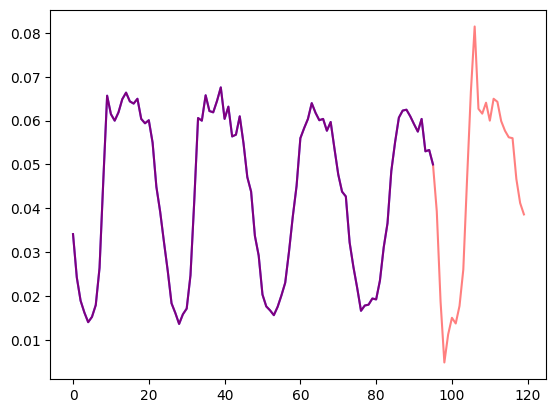

In [37]:
import matplotlib.pyplot as plt

num_of_samples = 4*prediction_length

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], color="blue")
axes.plot(
    test_example["target"][-num_of_samples - prediction_length :],
    color="red",
    alpha=0.5,
)

plt.show()

Let's make a variable for the train/test split:

In [38]:
train_dataset = dataset.train
test_dataset = dataset.test

## Define Transformations

Next, we define the transformations for the data, in particular for the creation of the time features (based on the dataset or universal ones).

Again, we'll use the GluonTS library for this. We define a `Chain` of transformations (which is a bit comparable to `torchvision.transforms.Compose` for images). It allows us to combine several transformations into a single pipeline.

In [39]:
from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

The transformations below are annotated with comments, to explain what they do. At a high level, we will iterate over the individual time series of our dataset and add/remove fields or features:

In [40]:
from transformers import PretrainedConfig
from gluonts.time_feature import time_features_from_frequency_str

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

## Define `InstanceSplitter`

For training/validation/testing we next create an `InstanceSplitter` which is used to sample windows from the dataset (as, remember, we can't pass the entire history of values to the model due to time- and memory constraints).

The instance splitter samples random `context_length` sized and subsequent `prediction_length` sized windows from the data, and appends a `past_` or `future_` key to any temporal keys for the respective windows. This makes sure that the `values` will be split into `past_values` and subsequent `future_values` keys, which will serve as the encoder and decoder inputs respectively. The same happens for any keys in the `time_series_fields` argument:

In [41]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

## Create PyTorch DataLoaders

Next, it's time to create PyTorch DataLoaders, which allow us to have batches of (input, output) pairs - or in other words (`past_values`, `future_values`).

In [42]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream, is_train=True)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [43]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

## Evaluate on Autoformer

We have already pre-trained an Autoformer model on this dataset so we can just fetch the model and evaluate it on the test set:

In [44]:
from transformers import AutoformerConfig, AutoformerForPrediction

In [45]:
config = AutoformerConfig.from_pretrained("kashif/autoformer-traffic-hourly")

In [46]:
test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

## Inference

At inference time, we will use the model's  `generate()` method for predicting `predection_length` into the future from the very last context window of each time series in the training set.  

In [47]:
model = AutoformerForPrediction.from_pretrained("kashif/autoformer-traffic-hourly")

In [48]:
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device
model.to(device)

model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

The model outputs a tensor of shape (`batch_size`, `number of samples`, `prediction length`, `input_size`). 

In this case, we get `100` possible values for the next `24` hours for each of the  time series in the test dataloader batch which if you recall from above is `64`:

In [49]:
forecasts_[0].shape

(64, 100, 24)

We'll stack them vertically, to get forecasts for all time-series in the test dataset: We have `7` rolling windows in the test set which is why we end up with a total of `7 * 862 = 6034` predictions:   

In [50]:
import numpy as np

forecasts = np.vstack(forecasts_)
print(forecasts.shape)

(6034, 100, 24)


We can evaluate the resulting forecast with respect to the ground truth out of sample values present in the test set. For that, we'll use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library, which includes the [MASE](https://huggingface.co/spaces/evaluate-metric/mase) metrics.

We calculate the metric for each time series in the dataset and return the average:

In [51]:
from tqdm.autonotebook import tqdm
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
for item_id, ts in enumerate(tqdm(test_dataset)):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])

  0%|          | 0/6034 [00:00<?, ?it/s]

In [52]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 0.9092493026949344


To plot the prediction for any time series with respect the ground truth test data we define the following helper:

In [53]:
import matplotlib.dates as mdates
import pandas as pd

test_ds = list(test_dataset)

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_ds[ts_index][FieldName.START],
        periods=len(test_ds[ts_index][FieldName.TARGET]),
        freq=test_ds[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.plot(
        index[-5*prediction_length:], 
        test_ds[ts_index]["target"][-5*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.gcf().autofmt_xdate()
    plt.legend(loc="best")
    plt.show()

For example:

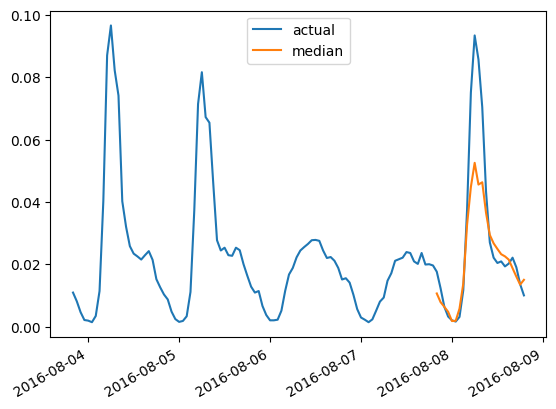

In [54]:
plot(4)

## DLinear

A probablistic DLinear is implemented in `glounts` and thus we can train and evaluate it relatively quickly here:

In [17]:
from gluonts.torch.model.d_linear.estimator import DLinearEstimator

estimator = DLinearEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    scaling="std",
    hidden_dimension=2,
    
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50)
)

In [18]:
predictor = estimator.train(
    training_data=train_dataset, 
    cache_data=True, 
    shuffle_buffer_length=1024
)

Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytor

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 100: 'train_loss' reached -2.16697 (best -2.16697), saving model to '/mnt/scratch/kashif/notebooks/examples/lightning_logs/version_1/checkpoints/epoch=0-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 200: 'train_loss' reached -2.64898 (best -2.64898), saving model to '/mnt/scratch/kashif/notebooks/examples/lightning_logs/version_1/checkpoints/epoch=1-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 300: 'train_loss' reached -2.75313 (best -2.75313), saving model to '/mnt/scratch/kashif/notebooks/examples/lightning_logs/version_1/checkpoints/epoch=2-step=300.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 400: 'train_loss' reached -2.81704 (best -2.81704), saving model to '/mnt/scratch/kashif/notebooks/examples/lightning_logs/version_1/checkpoints/epoch=3-step=400.ckpt' as top 1
INFO:pytorch_lightning.utilities.ran

In [19]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [20]:
d_linear_forecasts = list(forecast_it)
d_linear_tss = list(ts_it)

In [21]:
evaluator = Evaluator()

agg_metrics, _ = evaluator(iter(d_linear_tss), iter(d_linear_forecasts))

Running evaluation: 6034it [00:00, 70109.56it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:138: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [24]:
print(agg_metrics["MASE"])

0.9693592730002069


We can also plot the predictions from our trained DLinear model via this helper:

In [26]:
def plot_gluonts(index):
    plt.plot(d_linear_tss[index][-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target")
    d_linear_forecasts[index].plot(show_label=True,  color='g')
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

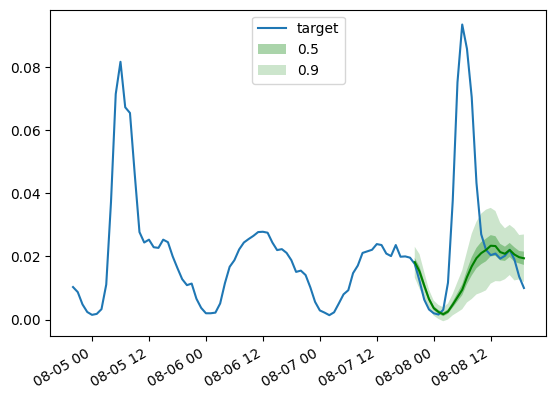

In [27]:
plot_gluonts(4)

The `traffic` dataset has a distributional shift in the sensor patterns between weekdays and weekends. So what is going on here? Since the DLinear model has no capacity to incorporate covariates, in particular any date-time features, the context window we give it does not have enough information to figure out if the prediction is for the weekend or weekday. Thus the model will predict the more common of the patterns, namely the the weekdays leading to poorer performance on weekends. Of course, by giving it a larger context window a linear model will figure out the weekly pattern but perhaps there is a monthly or quaterly pattern in the data which would require bigger and bigger contexts.

## Conclusion

How do we compare against other models? The test set MASE metrics from the different models  we have are below:

|Dataset | 	 Transformer (uni.) |   	 Transformer (mv.)  | Informer (uni.)| Informer (mv.) | Autoformer (uni.) | DLinear |
|:--:|:--:| :--:| :--:| :--:|  :--:|  :--:| 
|`Traffic` 	| **0.876** | 1.046 | 0.924 | 1.131  | 0.910 | 0.969 |

As one can observe, the multivariate forecasts are typically _worse_ than the univariate ones, the reason being the difficulty in estimating the cross-series correlations/relationships. The additional variance added by the estimates often harms the resulting forecasts or the model learns spurious correlations. We refer to [this paper](https://openreview.net/forum?id=GpW327gxLTF) for further reading. Multivariate models tend to work well when trained on a lot of data. However, when one compares  univariate models with multivariate models, especially on smaller open datasets, the univariate models give better metrics. By comparing the linear model with equivalent-sized univariate transformers or in fact any other neural univariate model, one will typically get better performance.

We also observe that the vanilla Univariate Transformer still performs best here.